In [1]:
import os
import pandas as pd

In [2]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle
from fastkaggle import *

In [3]:
comp = 'skin-cancer-binary-classification-dataset/Skin_Data'
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')
display(path)

Path('../input/skin-cancer-binary-classification-dataset/Skin_Data')

In [4]:
from fastai.vision.all import *
set_seed(42)
path.ls()

(#2) [Path('../input/skin-cancer-binary-classification-dataset/Skin_Data/Cancer'),Path('../input/skin-cancer-binary-classification-dataset/Skin_Data/Non_Cancer')]

In [5]:
trn_path = path
files = get_image_files(trn_path)
tst_path = path

(488, 430)


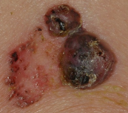

In [6]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [7]:
from fastcore.parallel import *
def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(170, 160)    6
(150, 140)    5
(200, 170)    4
(120, 120)    4
(170, 150)    4
             ..
(620, 150)    1
(240, 150)    1
(310, 350)    1
(180, 190)    1
(380, 350)    1
Length: 222, dtype: int64

In [8]:
traintest=[]
paths=[]
labels=[]
for dirname, _, filenames in os.walk('../input/skin-cancer-binary-classification-dataset/Skin_Data'):
    for filename in filenames:
        paths+=[os.path.join(dirname, filename)]
        labels+=[dirname.split('/')[-2]]
        traintest+=[dirname.split('/')[-1]]
print(paths[0:3])
print(labels[0:3])
print(traintest[0:3])

['../input/skin-cancer-binary-classification-dataset/Skin_Data/Cancer/Training/341-2.JPG', '../input/skin-cancer-binary-classification-dataset/Skin_Data/Cancer/Training/236-2.JPG', '../input/skin-cancer-binary-classification-dataset/Skin_Data/Cancer/Training/156.JPG']
['Cancer', 'Cancer', 'Cancer']
['Training', 'Training', 'Training']


In [9]:
data_df=pd.DataFrame(columns=['path','label','traintest'])
data_df['traintest']=traintest
data_df['path']=paths
data_df['label']=labels
display(data_df)
display(data_df['label'].value_counts())

,path,label,traintest
0,../input/skin-cancer-binary-classification-dataset/Skin_Data/Cancer/Training/341-2.JPG,Cancer,Training
1,../input/skin-cancer-binary-classification-dataset/Skin_Data/Cancer/Training/236-2.JPG,Cancer,Training
2,../input/skin-cancer-binary-classification-dataset/Skin_Data/Cancer/Training/156.JPG,Cancer,Training
3,../input/skin-cancer-binary-classification-dataset/Skin_Data/Cancer/Training/650-2.JPG,Cancer,Training
4,../input/skin-cancer-binary-classification-dataset/Skin_Data/Cancer/Training/1714-01.jpg,Cancer,Training
...,...,...,...
283,../input/skin-cancer-binary-classification-dataset/Skin_Data/Non_Cancer/Testing/1995-1.JPG,Non_Cancer,Testing
284,../input/skin-cancer-binary-classification-dataset/Skin_Data/Non_Cancer/Testing/199-2.JPG,Non_Cancer,Testing
285,../input/skin-cancer-binary-classification-dataset/Skin_Data/Non_Cancer/Testing/1341-2.JPG,Non_Cancer,Testing
286,../input/skin-cancer-binary-classification-dataset/Skin_Data/Non_Cancer/Testing/1708-3.JPG,Non_Cancer,Testing


Non_Cancer    204
Cancer         84
Name: label, dtype: int64

In [10]:
train_df=data_df[data_df['traintest']=='Training']
test_df=data_df[data_df['traintest']=='Testing']
train_df=train_df.sample(frac=1).reset_index(drop=True)
test_df=test_df.sample(frac=1).reset_index(drop=True)

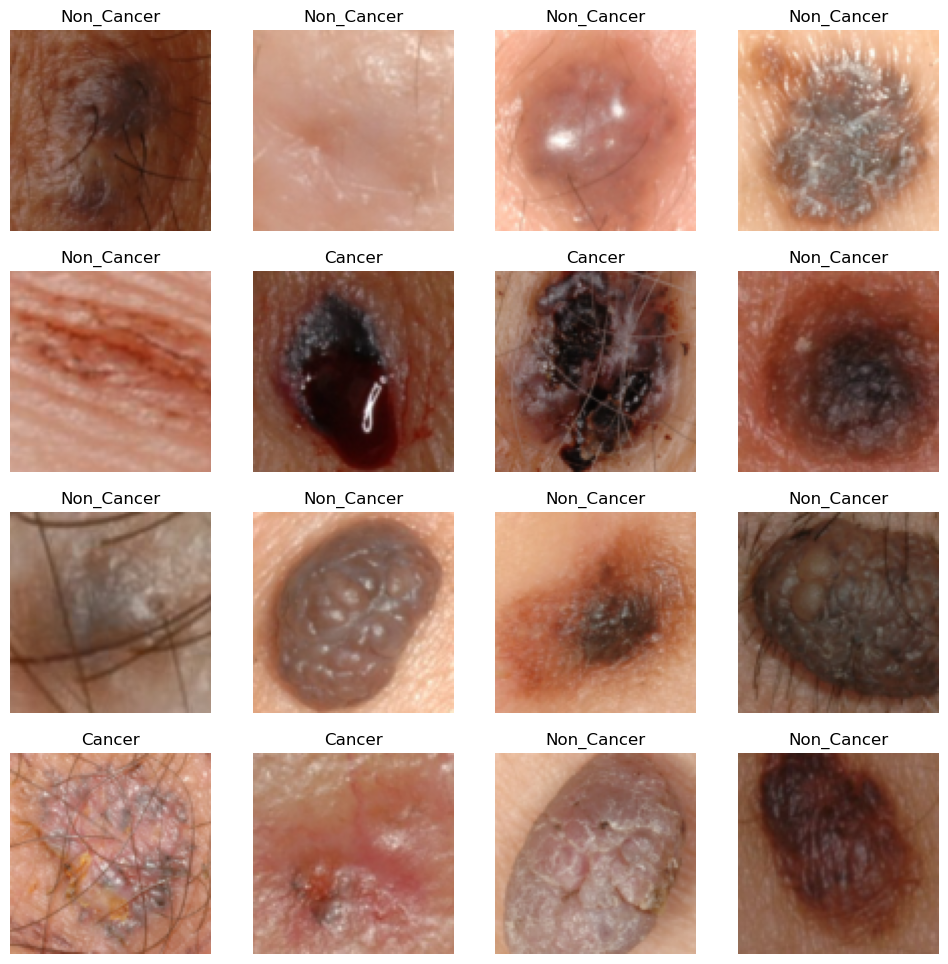

In [11]:
#### ImageDataLoaders.from_df
dls = ImageDataLoaders.from_df(train_df, 
                               fn_col=0, #path
                               label_col=1, #label
                               valid_pct=0.2,
                               folder='', 
                               item_tfms=Resize(100))
dls.show_batch(max_n=16)

In [12]:
learn = vision_learner(dls, 'resnet26', metrics=error_rate, path='.').to_fp16()

SuggestedLRs(valley=0.001737800776027143, slide=0.04786301031708717)

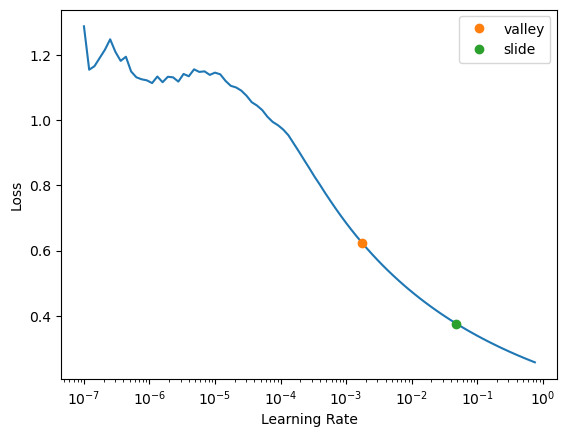

In [13]:
learn.lr_find(suggest_funcs=(valley, slide))

In [14]:
learn.fine_tune(10,0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.191283,1.274735,0.500000,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.435481,1.143534,0.437500,00:01
1,0.449882,1.073861,0.437500,00:01
2,0.514713,1.326676,0.187500,00:01
3,0.391412,0.922446,0.125000,00:01
4,0.313563,1.040764,0.125000,00:01
5,0.260255,1.037313,0.125000,00:01
6,0.223020,0.966424,0.125000,00:01
7,0.193323,0.870292,0.125000,00:01
8,0.171560,0.807170,0.125000,00:01
9,0.153466,0.696862,0.125000,00:01


In [21]:
from sklearn.metrics import classification_report
print(classification_report(test_true,test_pred,target_names=dls.vocab,digits=4))

              precision    recall  f1-score   support

      Cancer     0.6111    0.5238    0.5641        42
  Non_Cancer     0.8810    0.9136    0.8970       162

    accuracy                         0.8333       204
   macro avg     0.7460    0.7187    0.7305       204
weighted avg     0.8254    0.8333    0.8284       204



Predicted class: Cancer
Prediction probabilities: tensor([0.7479, 0.2521])


('Cancer', tensor([0.7479, 0.2521]))

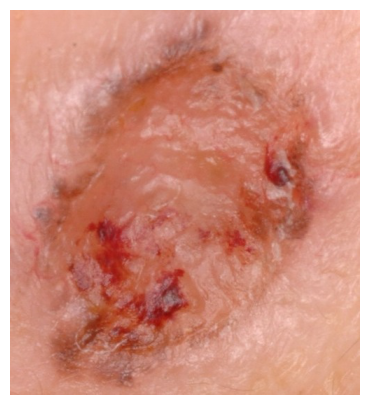

In [22]:
def predict_image(image_path):
    # Load the image
    img = PILImage.create(image_path)
    
    # Display the image
    img.show()
    
    # Make prediction
    pred_class, pred_idx, outputs = learn.predict(img)
    
    # Print the prediction
    print(f"Predicted class: {pred_class}")
    print(f"Prediction probabilities: {outputs}")
    
    return pred_class, outputs

# Example usage
# Provide the path to your image file
user_image_path = '/kaggle/input/cancer-dataset-testing/cancer-01.jpg'
predict_image(user_image_path)

In [25]:
# After training your model
learn.export('skin_cancer_model.pkl')

In [ ]:
import pathlib
from fastai.vision.all import *
def predict_image_fastai(image_path):
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    learn = load_learner('MainWebsite/skin_cancer_model.pkl')
    pathlib.PosixPath = temp
    img = PILImage.create(image_path)
    pred_class, pred_idx, outputs = learn.predict(img)
    return pred_class
